In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchio as tio
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchio")

from utils.utils import train_3d, validate_3d, validate_3d_patch
from utils.vis import plot_mri
from utils.dataset import BrainMRIDataset
from utils.loss import DiceCrossEntropyLoss, DiceFocalLoss
from models import UNet3D, AttentionUNet
from monai.networks.nets import UNet, SegResNet, UNETR

## Constants

In [2]:
ROOT_DIR = './Data'
BATCH_SIZE = 1
EPOCHS = 300
NUM_CLASSES = 4
NUM_WORKERS=16
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
PATCH_SIZE = 64
QUEUE_LENGTH = 200

## Transforms

In [3]:
# TorchIO transformations for augmentation
train_transform = tio.Compose([
    # tio.RandomAffine(scales=(0.9, 1.1)),
    # tio.RandomElasticDeformation(num_control_points=(7, 7, 7), max_displacement=(4, 4, 4)),
    # tio.RandomFlip(axes=(0, 1, 2)),
    # tio.RandomBiasField(coefficients=(0.1, 0.3)),
    tio.RescaleIntensity((0, 1)),  # Normalize intensity to [0, 1]
    tio.ZNormalization(),
])

val_transform = tio.Compose([
    tio.RescaleIntensity((0, 1)),  # Only normalize intensity for validation
    tio.ZNormalization(),
])

In [4]:
# Create datasets
train_dataset = BrainMRIDataset(os.path.join(ROOT_DIR, 'train'), transform=train_transform)
val_dataset = BrainMRIDataset(os.path.join(ROOT_DIR, 'val'), transform=val_transform)

##################### Training Data Loader #####################
sampler = tio.data.UniformSampler(PATCH_SIZE)

# Queue for training
patches_queue = tio.Queue(
    subjects_dataset=train_dataset,
    max_length=QUEUE_LENGTH,
    samples_per_volume=16,
    sampler=sampler,
    num_workers=0,
    shuffle_subjects=True,
    shuffle_patches=True,
)

# Create DataLoaders
train_loader = tio.SubjectsLoader(patches_queue, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Visualization

torch.Size([1, 1, 64, 64, 64]) torch.Size([1, 1, 64, 64, 64])


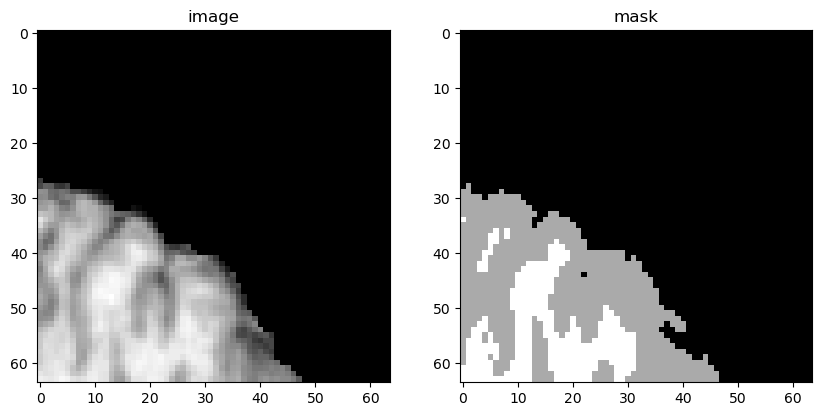

In [6]:
slice_idx = 40
for i, batch in enumerate(train_loader):
    if i == 6:
        images, masks = batch["image"]["data"], batch["mask"]["data"]
        print(images.shape, masks.shape)
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(images[0, 0, :, :, slice_idx].numpy(), cmap='gray')
        axs[0].set_title('image')
        axs[1].imshow(masks[0, 0, :, :, slice_idx].numpy(), cmap='gray')
        axs[1].set_title('mask')
        plt.show()
        break

## Models

In [5]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,  
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=4,
    norm="instance",  # Use Instance Normalization
    dropout=0.2       # Add dropout
)
# model = UNETR(in_channels=1, out_channels=4, img_size=(256,128,258), feature_size=32, norm_name='batch')
model = model.to(DEVICE)

## Loss & Optimizer

In [6]:
# class_weights = train_dataset.calculate_class_weights_log(num_classes=4).to(DEVICE)
# criterion = DiceCrossEntropyLoss(dice_weight=1.0, ce_weight=0.0, is_3d=True, class_weights=class_weights)
criterion = DiceFocalLoss(alpha=0.5, gamma=2, is_3d=True, ignore_background=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

## Training

In [9]:
best_avg_dice = 0
for epoch in range(EPOCHS):
    train_avg_loss, train_avg_dice, train_csf_dice, train_gm_dice, train_wm_dice = train_3d(model, train_loader, criterion, optimizer, DEVICE, epoch, EPOCHS, NUM_CLASSES)
    val_loss, val_avg_dice, val_csf_dice, val_gm_dice, val_wm_dice = validate_3d_patch(model, val_dataset, criterion, epoch, EPOCHS, DEVICE, NUM_CLASSES, PATCH_SIZE, BATCH_SIZE, NUM_WORKERS)

    scheduler.step()
    if val_avg_dice > best_avg_dice:
        best_avg_dice = val_avg_dice
        torch.save(model.state_dict(), 'best_model_3d.pth')
        print(f'Best model saved with dice score: {best_avg_dice}\n')

Training Epoch 1/300: 100%|██████████| 160/160 [00:40<00:00,  3.93it/s, Loss=0.0996, Avg Dice=0.516, CSF Dice=5.25e-10, GM Dice=0.774, WM Dice=0.332] 


Epoch 1, Loss: 0.3577
Epoch 1, Dice: 0.5472 CSF Dice: 0.3126 GM Dice: 0.5641 WM Dice: 0.3993


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 1/300, Loss: 0.3481, Avg Dice: 0.5328, CSF Dice: 0.0000, GM Dice: 0.7747, WM Dice: 0.3625
Best model saved with dice score: 0.5327752232732511



Training Epoch 2/300: 100%|██████████| 160/160 [00:39<00:00,  4.07it/s, Loss=0.065, Avg Dice=0.682, CSF Dice=0.0415, GM Dice=0.83, WM Dice=0.862]     


Epoch 2, Loss: 0.2965
Epoch 2, Dice: 0.6119 CSF Dice: 0.2396 GM Dice: 0.6954 WM Dice: 0.5681


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 2/300, Loss: 0.3156, Avg Dice: 0.6475, CSF Dice: 0.0035, GM Dice: 0.8232, WM Dice: 0.7681
Best model saved with dice score: 0.6475229666684754



Training Epoch 3/300: 100%|██████████| 160/160 [00:38<00:00,  4.14it/s, Loss=0.061, Avg Dice=0.675, CSF Dice=1.64e-8, GM Dice=0.886, WM Dice=0.816]   


Epoch 3, Loss: 0.2698
Epoch 3, Dice: 0.6200 CSF Dice: 0.1809 GM Dice: 0.7293 WM Dice: 0.6045


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 3/300, Loss: 0.2995, Avg Dice: 0.7018, CSF Dice: 0.1316, GM Dice: 0.8667, WM Dice: 0.8130
Best model saved with dice score: 0.701796866953373



Training Epoch 4/300: 100%|██████████| 160/160 [00:38<00:00,  4.16it/s, Loss=0.114, Avg Dice=0.404, CSF Dice=1.88e-9, GM Dice=0.43, WM Dice=0.19]      


Epoch 4, Loss: 0.2868
Epoch 4, Dice: 0.5656 CSF Dice: 0.0451 GM Dice: 0.6771 WM Dice: 0.6027


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 4/300, Loss: 0.3617, Avg Dice: 0.5410, CSF Dice: 0.0371, GM Dice: 0.5073, WM Dice: 0.6322


Training Epoch 5/300: 100%|██████████| 160/160 [00:39<00:00,  4.01it/s, Loss=0.135, Avg Dice=0.533, CSF Dice=0.0823, GM Dice=0.731, WM Dice=0.816]    


Epoch 5, Loss: 0.2657
Epoch 5, Dice: 0.5860 CSF Dice: 0.0472 GM Dice: 0.7138 WM Dice: 0.6265


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Epoch 5/300, Loss: 0.3048, Avg Dice: 0.7019, CSF Dice: 0.1887, GM Dice: 0.8215, WM Dice: 0.8016
Best model saved with dice score: 0.7018634304404259



Training Epoch 6/300: 100%|██████████| 160/160 [00:38<00:00,  4.15it/s, Loss=0.0781, Avg Dice=0.588, CSF Dice=1.37e-8, GM Dice=0.864, WM Dice=0.491]  


Epoch 6, Loss: 0.2552
Epoch 6, Dice: 0.6154 CSF Dice: 0.0547 GM Dice: 0.7418 WM Dice: 0.7063


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


Epoch 6/300, Loss: 0.2924, Avg Dice: 0.7261, CSF Dice: 0.2173, GM Dice: 0.8668, WM Dice: 0.8246
Best model saved with dice score: 0.7260597757995129



Training Epoch 7/300: 100%|██████████| 160/160 [00:39<00:00,  4.08it/s, Loss=0.0988, Avg Dice=0.681, CSF Dice=0.414, GM Dice=0.841, WM Dice=0.754]    


Epoch 7, Loss: 0.2476
Epoch 7, Dice: 0.6270 CSF Dice: 0.0965 GM Dice: 0.7690 WM Dice: 0.6900


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 7/300, Loss: 0.2886, Avg Dice: 0.7343, CSF Dice: 0.2594, GM Dice: 0.8523, WM Dice: 0.8299
Best model saved with dice score: 0.7343444377183914



Training Epoch 8/300: 100%|██████████| 160/160 [00:39<00:00,  4.05it/s, Loss=0.0621, Avg Dice=0.681, CSF Dice=9.09e-8, GM Dice=0.928, WM Dice=0.798]  


Epoch 8, Loss: 0.2669
Epoch 8, Dice: 0.6001 CSF Dice: 0.0928 GM Dice: 0.7062 WM Dice: 0.6601


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 8/300, Loss: 0.2887, Avg Dice: 0.7661, CSF Dice: 0.3697, GM Dice: 0.8656, WM Dice: 0.8336
Best model saved with dice score: 0.7661415413022041



Training Epoch 9/300: 100%|██████████| 160/160 [00:39<00:00,  4.02it/s, Loss=0.0809, Avg Dice=0.513, CSF Dice=1.09e-8, GM Dice=0.915, WM Dice=0.139]   


Epoch 9, Loss: 0.2604
Epoch 9, Dice: 0.6032 CSF Dice: 0.1132 GM Dice: 0.7109 WM Dice: 0.6439


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


Epoch 9/300, Loss: 0.2892, Avg Dice: 0.7413, CSF Dice: 0.3194, GM Dice: 0.8363, WM Dice: 0.8142


Training Epoch 10/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.0598, Avg Dice=0.686, CSF Dice=4.76e-8, GM Dice=0.898, WM Dice=0.853]  


Epoch 10, Loss: 0.2412
Epoch 10, Dice: 0.6197 CSF Dice: 0.1404 GM Dice: 0.7310 WM Dice: 0.6522


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Epoch 10/300, Loss: 0.2862, Avg Dice: 0.7822, CSF Dice: 0.4421, GM Dice: 0.8586, WM Dice: 0.8324
Best model saved with dice score: 0.7821685895323753



Training Epoch 11/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.103, Avg Dice=0.674, CSF Dice=0.303, GM Dice=0.791, WM Dice=0.778]     


Epoch 11, Loss: 0.2381
Epoch 11, Dice: 0.6341 CSF Dice: 0.1448 GM Dice: 0.7571 WM Dice: 0.6832


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Epoch 11/300, Loss: 0.2877, Avg Dice: 0.7661, CSF Dice: 0.3594, GM Dice: 0.8683, WM Dice: 0.8411


Training Epoch 12/300: 100%|██████████| 160/160 [00:39<00:00,  4.09it/s, Loss=0.0531, Avg Dice=0.847, CSF Dice=0.723, GM Dice=0.897, WM Dice=0.883]    


Epoch 12, Loss: 0.2298
Epoch 12, Dice: 0.6528 CSF Dice: 0.2063 GM Dice: 0.7627 WM Dice: 0.6894


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


Epoch 12/300, Loss: 0.2798, Avg Dice: 0.8170, CSF Dice: 0.5648, GM Dice: 0.8630, WM Dice: 0.8450
Best model saved with dice score: 0.8169736564159393



Training Epoch 13/300: 100%|██████████| 160/160 [00:41<00:00,  3.87it/s, Loss=0.158, Avg Dice=0.585, CSF Dice=0.583, GM Dice=0.654, WM Dice=0.786]    


Epoch 13, Loss: 0.2234
Epoch 13, Dice: 0.6520 CSF Dice: 0.1720 GM Dice: 0.7830 WM Dice: 0.6877


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Epoch 13/300, Loss: 0.2780, Avg Dice: 0.8237, CSF Dice: 0.5726, GM Dice: 0.8801, WM Dice: 0.8462
Best model saved with dice score: 0.8237110376358032



Training Epoch 14/300: 100%|██████████| 160/160 [00:39<00:00,  4.08it/s, Loss=0.0567, Avg Dice=0.7, CSF Dice=1.19e-8, GM Dice=0.926, WM Dice=0.876]   


Epoch 14, Loss: 0.2311
Epoch 14, Dice: 0.6601 CSF Dice: 0.2671 GM Dice: 0.7490 WM Dice: 0.6587


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


Epoch 14/300, Loss: 0.2795, Avg Dice: 0.8218, CSF Dice: 0.5762, GM Dice: 0.8742, WM Dice: 0.8409


Training Epoch 15/300: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s, Loss=0.0601, Avg Dice=0.755, CSF Dice=0.352, GM Dice=0.846, WM Dice=0.846]   


Epoch 15, Loss: 0.2415
Epoch 15, Dice: 0.6504 CSF Dice: 0.2371 GM Dice: 0.7674 WM Dice: 0.6527


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


Epoch 15/300, Loss: 0.2846, Avg Dice: 0.7975, CSF Dice: 0.4766, GM Dice: 0.8719, WM Dice: 0.8462


Training Epoch 16/300: 100%|██████████| 160/160 [00:38<00:00,  4.17it/s, Loss=0.048, Avg Dice=0.779, CSF Dice=0.464, GM Dice=0.838, WM Dice=0.823]    


Epoch 16, Loss: 0.2179
Epoch 16, Dice: 0.6750 CSF Dice: 0.2134 GM Dice: 0.7873 WM Dice: 0.7255


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Epoch 16/300, Loss: 0.2774, Avg Dice: 0.8375, CSF Dice: 0.6266, GM Dice: 0.8791, WM Dice: 0.8482
Best model saved with dice score: 0.8375024646520615



Training Epoch 17/300: 100%|██████████| 160/160 [00:41<00:00,  3.85it/s, Loss=0.063, Avg Dice=0.638, CSF Dice=3.33e-7, GM Dice=0.868, WM Dice=0.683]  


Epoch 17, Loss: 0.2182
Epoch 17, Dice: 0.6667 CSF Dice: 0.2638 GM Dice: 0.7575 WM Dice: 0.6790


100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


Epoch 17/300, Loss: 0.2755, Avg Dice: 0.8326, CSF Dice: 0.6297, GM Dice: 0.8625, WM Dice: 0.8419


Training Epoch 18/300: 100%|██████████| 160/160 [00:45<00:00,  3.54it/s, Loss=0.0792, Avg Dice=0.604, CSF Dice=9.9e-9, GM Dice=0.762, WM Dice=0.666]  


Epoch 18, Loss: 0.2114
Epoch 18, Dice: 0.7101 CSF Dice: 0.3679 GM Dice: 0.8009 WM Dice: 0.6956


100%|██████████| 5/5 [00:24<00:00,  4.89s/it]


Epoch 18/300, Loss: 0.2860, Avg Dice: 0.8141, CSF Dice: 0.5852, GM Dice: 0.8571, WM Dice: 0.8194


Training Epoch 19/300: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s, Loss=0.058, Avg Dice=0.691, CSF Dice=3.33e-7, GM Dice=0.921, WM Dice=0.85]   


Epoch 19, Loss: 0.2294
Epoch 19, Dice: 0.6614 CSF Dice: 0.2305 GM Dice: 0.7975 WM Dice: 0.6548


100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


Epoch 19/300, Loss: 0.2767, Avg Dice: 0.8282, CSF Dice: 0.6011, GM Dice: 0.8793, WM Dice: 0.8367


Training Epoch 20/300: 100%|██████████| 160/160 [00:47<00:00,  3.34it/s, Loss=0.158, Avg Dice=0.553, CSF Dice=0.233, GM Dice=0.78, WM Dice=0.802]     


Epoch 20, Loss: 0.2239
Epoch 20, Dice: 0.6763 CSF Dice: 0.2410 GM Dice: 0.7816 WM Dice: 0.7182


100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


Epoch 20/300, Loss: 0.2718, Avg Dice: 0.8520, CSF Dice: 0.6745, GM Dice: 0.8848, WM Dice: 0.8525
Best model saved with dice score: 0.8519794642925262



Training Epoch 21/300: 100%|██████████| 160/160 [00:51<00:00,  3.12it/s, Loss=0.0859, Avg Dice=0.492, CSF Dice=1e-6, GM Dice=0.93, WM Dice=0.0399]     


Epoch 21, Loss: 0.2077
Epoch 21, Dice: 0.7292 CSF Dice: 0.3859 GM Dice: 0.8169 WM Dice: 0.7280


100%|██████████| 5/5 [00:27<00:00,  5.57s/it]


Epoch 21/300, Loss: 0.2762, Avg Dice: 0.8168, CSF Dice: 0.5495, GM Dice: 0.8717, WM Dice: 0.8500


Training Epoch 22/300: 100%|██████████| 160/160 [00:45<00:00,  3.50it/s, Loss=0.0555, Avg Dice=0.776, CSF Dice=0.539, GM Dice=0.825, WM Dice=0.76]     


Epoch 22, Loss: 0.2048
Epoch 22, Dice: 0.7508 CSF Dice: 0.4864 GM Dice: 0.8396 WM Dice: 0.7128


100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Epoch 22/300, Loss: 0.2766, Avg Dice: 0.8396, CSF Dice: 0.6256, GM Dice: 0.8824, WM Dice: 0.8545


Training Epoch 23/300: 100%|██████████| 160/160 [00:52<00:00,  3.04it/s, Loss=0.0517, Avg Dice=0.814, CSF Dice=0.603, GM Dice=0.87, WM Dice=0.816]     


Epoch 23, Loss: 0.2148
Epoch 23, Dice: 0.6986 CSF Dice: 0.3282 GM Dice: 0.7947 WM Dice: 0.7063


100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


Epoch 23/300, Loss: 0.2734, Avg Dice: 0.8447, CSF Dice: 0.6477, GM Dice: 0.8823, WM Dice: 0.8527


Training Epoch 24/300: 100%|██████████| 160/160 [00:42<00:00,  3.77it/s, Loss=0.0323, Avg Dice=0.871, CSF Dice=0.749, GM Dice=0.877, WM Dice=0.871]    


Epoch 24, Loss: 0.2223
Epoch 24, Dice: 0.6663 CSF Dice: 0.2680 GM Dice: 0.7727 WM Dice: 0.6700


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


Epoch 24/300, Loss: 0.2742, Avg Dice: 0.8446, CSF Dice: 0.6524, GM Dice: 0.8830, WM Dice: 0.8469


Training Epoch 25/300: 100%|██████████| 160/160 [00:41<00:00,  3.82it/s, Loss=0.0606, Avg Dice=0.681, CSF Dice=2.63e-8, GM Dice=0.925, WM Dice=0.804]


Epoch 25, Loss: 0.2091
Epoch 25, Dice: 0.7024 CSF Dice: 0.3342 GM Dice: 0.8005 WM Dice: 0.7106


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


Epoch 25/300, Loss: 0.2729, Avg Dice: 0.8520, CSF Dice: 0.6749, GM Dice: 0.8857, WM Dice: 0.8514
Best model saved with dice score: 0.8520120829343796



Training Epoch 26/300: 100%|██████████| 160/160 [00:42<00:00,  3.78it/s, Loss=0.0912, Avg Dice=0.462, CSF Dice=2e-7, GM Dice=0.851, WM Dice=5.35e-9]  


Epoch 26, Loss: 0.2384
Epoch 26, Dice: 0.6585 CSF Dice: 0.2867 GM Dice: 0.7404 WM Dice: 0.6500


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


Epoch 26/300, Loss: 0.2723, Avg Dice: 0.8512, CSF Dice: 0.6812, GM Dice: 0.8780, WM Dice: 0.8496


Training Epoch 27/300: 100%|██████████| 160/160 [00:41<00:00,  3.83it/s, Loss=0.0704, Avg Dice=0.771, CSF Dice=0.422, GM Dice=0.837, WM Dice=0.897]    


Epoch 27, Loss: 0.2095
Epoch 27, Dice: 0.6873 CSF Dice: 0.2614 GM Dice: 0.8046 WM Dice: 0.7230


100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


Epoch 27/300, Loss: 0.2745, Avg Dice: 0.8455, CSF Dice: 0.6672, GM Dice: 0.8711, WM Dice: 0.8480


Training Epoch 28/300: 100%|██████████| 160/160 [00:42<00:00,  3.80it/s, Loss=0.0629, Avg Dice=0.674, CSF Dice=1.55e-9, GM Dice=0.845, WM Dice=0.863] 


Epoch 28, Loss: 0.2105
Epoch 28, Dice: 0.7228 CSF Dice: 0.4049 GM Dice: 0.7881 WM Dice: 0.7369


100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


Epoch 28/300, Loss: 0.2706, Avg Dice: 0.8425, CSF Dice: 0.6378, GM Dice: 0.8802, WM Dice: 0.8562


Training Epoch 29/300: 100%|██████████| 160/160 [00:44<00:00,  3.58it/s, Loss=0.039, Avg Dice=0.848, CSF Dice=0.566, GM Dice=0.912, WM Dice=0.94]    


Epoch 29, Loss: 0.2058
Epoch 29, Dice: 0.7159 CSF Dice: 0.3994 GM Dice: 0.7993 WM Dice: 0.7106


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


Epoch 29/300, Loss: 0.2790, Avg Dice: 0.8334, CSF Dice: 0.6091, GM Dice: 0.8755, WM Dice: 0.8532


Training Epoch 30/300: 100%|██████████| 160/160 [00:42<00:00,  3.79it/s, Loss=0.0805, Avg Dice=0.634, CSF Dice=3.75e-9, GM Dice=0.835, WM Dice=0.718] 


Epoch 30, Loss: 0.2149
Epoch 30, Dice: 0.7171 CSF Dice: 0.4171 GM Dice: 0.8071 WM Dice: 0.6761


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 30/300, Loss: 0.2720, Avg Dice: 0.8359, CSF Dice: 0.6659, GM Dice: 0.8488, WM Dice: 0.8328


Training Epoch 31/300: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s, Loss=0.0675, Avg Dice=0.67, CSF Dice=9.84e-10, GM Dice=0.841, WM Dice=0.859]


Epoch 31, Loss: 0.2065
Epoch 31, Dice: 0.7224 CSF Dice: 0.3666 GM Dice: 0.8146 WM Dice: 0.7430


100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 31/300, Loss: 0.2704, Avg Dice: 0.8496, CSF Dice: 0.6939, GM Dice: 0.8619, WM Dice: 0.8468


Training Epoch 32/300: 100%|██████████| 160/160 [00:43<00:00,  3.65it/s, Loss=0.0692, Avg Dice=0.769, CSF Dice=0.561, GM Dice=0.789, WM Dice=0.789]    


Epoch 32, Loss: 0.2119
Epoch 32, Dice: 0.7518 CSF Dice: 0.5248 GM Dice: 0.8005 WM Dice: 0.7092


100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


Epoch 32/300, Loss: 0.2674, Avg Dice: 0.8657, CSF Dice: 0.7149, GM Dice: 0.8868, WM Dice: 0.8649
Best model saved with dice score: 0.8656808286905289



Training Epoch 33/300: 100%|██████████| 160/160 [00:45<00:00,  3.55it/s, Loss=0.0279, Avg Dice=0.907, CSF Dice=0.85, GM Dice=0.908, WM Dice=0.882]   


Epoch 33, Loss: 0.1957
Epoch 33, Dice: 0.7586 CSF Dice: 0.4984 GM Dice: 0.8224 WM Dice: 0.7492


100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Epoch 33/300, Loss: 0.2728, Avg Dice: 0.8615, CSF Dice: 0.7090, GM Dice: 0.8844, WM Dice: 0.8570


Training Epoch 34/300: 100%|██████████| 160/160 [00:38<00:00,  4.11it/s, Loss=0.125, Avg Dice=0.5, CSF Dice=8.33e-8, GM Dice=8.33e-8, WM Dice=1]       


Epoch 34, Loss: 0.2020
Epoch 34, Dice: 0.7202 CSF Dice: 0.3926 GM Dice: 0.8060 WM Dice: 0.7215


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Epoch 34/300, Loss: 0.2751, Avg Dice: 0.8413, CSF Dice: 0.6879, GM Dice: 0.8511, WM Dice: 0.8301


Training Epoch 35/300: 100%|██████████| 160/160 [00:38<00:00,  4.15it/s, Loss=0.0572, Avg Dice=0.935, CSF Dice=1, GM Dice=0.944, WM Dice=0.8]        


Epoch 35, Loss: 0.2126
Epoch 35, Dice: 0.7400 CSF Dice: 0.4369 GM Dice: 0.7972 WM Dice: 0.7522


100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


Epoch 35/300, Loss: 0.2673, Avg Dice: 0.8740, CSF Dice: 0.7477, GM Dice: 0.8883, WM Dice: 0.8638
Best model saved with dice score: 0.8740114718675613



Training Epoch 36/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.0464, Avg Dice=0.817, CSF Dice=0.699, GM Dice=0.816, WM Dice=0.77]     


Epoch 36, Loss: 0.2029
Epoch 36, Dice: 0.7313 CSF Dice: 0.4293 GM Dice: 0.8172 WM Dice: 0.7072


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Epoch 36/300, Loss: 0.2726, Avg Dice: 0.8609, CSF Dice: 0.7173, GM Dice: 0.8731, WM Dice: 0.8573


Training Epoch 37/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.0576, Avg Dice=0.788, CSF Dice=0.607, GM Dice=0.794, WM Dice=0.79]   


Epoch 37, Loss: 0.2023
Epoch 37, Dice: 0.7339 CSF Dice: 0.4250 GM Dice: 0.8023 WM Dice: 0.7377


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 37/300, Loss: 0.2689, Avg Dice: 0.8490, CSF Dice: 0.6712, GM Dice: 0.8699, WM Dice: 0.8590


Training Epoch 38/300: 100%|██████████| 160/160 [00:39<00:00,  4.03it/s, Loss=0.0712, Avg Dice=0.586, CSF Dice=9.9e-9, GM Dice=0.798, WM Dice=0.549] 


Epoch 38, Loss: 0.2011
Epoch 38, Dice: 0.7412 CSF Dice: 0.4692 GM Dice: 0.8127 WM Dice: 0.7094


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


Epoch 38/300, Loss: 0.2679, Avg Dice: 0.8767, CSF Dice: 0.7575, GM Dice: 0.8882, WM Dice: 0.8649
Best model saved with dice score: 0.8767173886299133



Training Epoch 39/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.0599, Avg Dice=0.657, CSF Dice=2.78e-8, GM Dice=0.873, WM Dice=0.758] 


Epoch 39, Loss: 0.2093
Epoch 39, Dice: 0.6961 CSF Dice: 0.3633 GM Dice: 0.7731 WM Dice: 0.6837


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 39/300, Loss: 0.2710, Avg Dice: 0.8669, CSF Dice: 0.7389, GM Dice: 0.8771, WM Dice: 0.8551


Training Epoch 40/300: 100%|██████████| 160/160 [00:39<00:00,  4.03it/s, Loss=0.0303, Avg Dice=0.9, CSF Dice=0.834, GM Dice=0.925, WM Dice=0.86]     


Epoch 40, Loss: 0.2046
Epoch 40, Dice: 0.7423 CSF Dice: 0.4690 GM Dice: 0.7864 WM Dice: 0.7504


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 40/300, Loss: 0.2657, Avg Dice: 0.8714, CSF Dice: 0.7536, GM Dice: 0.8765, WM Dice: 0.8595


Training Epoch 41/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.0676, Avg Dice=0.644, CSF Dice=1.64e-8, GM Dice=0.907, WM Dice=0.678]


Epoch 41, Loss: 0.2003
Epoch 41, Dice: 0.7505 CSF Dice: 0.4951 GM Dice: 0.8286 WM Dice: 0.6995


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


Epoch 41/300, Loss: 0.2689, Avg Dice: 0.8675, CSF Dice: 0.7212, GM Dice: 0.8859, WM Dice: 0.8669


Training Epoch 42/300: 100%|██████████| 160/160 [00:39<00:00,  4.01it/s, Loss=0.0885, Avg Dice=0.733, CSF Dice=1, GM Dice=0.806, WM Dice=0.128]       


Epoch 42, Loss: 0.2015
Epoch 42, Dice: 0.7527 CSF Dice: 0.4641 GM Dice: 0.8105 WM Dice: 0.7622


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 42/300, Loss: 0.2670, Avg Dice: 0.8716, CSF Dice: 0.7314, GM Dice: 0.8937, WM Dice: 0.8649


Training Epoch 43/300: 100%|██████████| 160/160 [00:40<00:00,  3.94it/s, Loss=0.0507, Avg Dice=0.837, CSF Dice=0.738, GM Dice=0.847, WM Dice=0.831]  


Epoch 43, Loss: 0.1914
Epoch 43, Dice: 0.7673 CSF Dice: 0.5397 GM Dice: 0.8310 WM Dice: 0.7238


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


Epoch 43/300, Loss: 0.2620, Avg Dice: 0.8803, CSF Dice: 0.7826, GM Dice: 0.8792, WM Dice: 0.8630
Best model saved with dice score: 0.880263552069664



Training Epoch 44/300: 100%|██████████| 160/160 [00:38<00:00,  4.12it/s, Loss=0.0834, Avg Dice=0.53, CSF Dice=1e-6, GM Dice=0.907, WM Dice=0.214]      


Epoch 44, Loss: 0.2008
Epoch 44, Dice: 0.7488 CSF Dice: 0.4910 GM Dice: 0.8038 WM Dice: 0.7412


100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


Epoch 44/300, Loss: 0.2694, Avg Dice: 0.8671, CSF Dice: 0.7405, GM Dice: 0.8740, WM Dice: 0.8579


Training Epoch 45/300: 100%|██████████| 160/160 [00:41<00:00,  3.82it/s, Loss=0.114, Avg Dice=0.581, CSF Dice=1e-6, GM Dice=0.326, WM Dice=1]        


Epoch 45, Loss: 0.2091
Epoch 45, Dice: 0.7420 CSF Dice: 0.4624 GM Dice: 0.8158 WM Dice: 0.7135


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


Epoch 45/300, Loss: 0.2611, Avg Dice: 0.8886, CSF Dice: 0.7947, GM Dice: 0.8926, WM Dice: 0.8708
Best model saved with dice score: 0.888566255569458



Training Epoch 46/300: 100%|██████████| 160/160 [01:02<00:00,  2.56it/s, Loss=0.0429, Avg Dice=0.876, CSF Dice=0.81, GM Dice=0.865, WM Dice=0.908]   


Epoch 46, Loss: 0.1918
Epoch 46, Dice: 0.7750 CSF Dice: 0.5275 GM Dice: 0.8313 WM Dice: 0.7603


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


Epoch 46/300, Loss: 0.2607, Avg Dice: 0.8888, CSF Dice: 0.7966, GM Dice: 0.8905, WM Dice: 0.8720
Best model saved with dice score: 0.8888373970985413



Training Epoch 47/300: 100%|██████████| 160/160 [01:08<00:00,  2.33it/s, Loss=0.126, Avg Dice=0.5, CSF Dice=1e-6, GM Dice=1, WM Dice=6.06e-9]         


Epoch 47, Loss: 0.1923
Epoch 47, Dice: 0.7718 CSF Dice: 0.5402 GM Dice: 0.8276 WM Dice: 0.7460


100%|██████████| 5/5 [00:34<00:00,  6.89s/it]


Epoch 47/300, Loss: 0.2626, Avg Dice: 0.8885, CSF Dice: 0.8058, GM Dice: 0.8854, WM Dice: 0.8663


Training Epoch 48/300: 100%|██████████| 160/160 [01:14<00:00,  2.15it/s, Loss=0.116, Avg Dice=0.336, CSF Dice=3.33e-7, GM Dice=0.345, WM Dice=7.14e-8]


Epoch 48, Loss: 0.2111
Epoch 48, Dice: 0.7415 CSF Dice: 0.5273 GM Dice: 0.7873 WM Dice: 0.6857


100%|██████████| 5/5 [00:30<00:00,  6.00s/it]


Epoch 48/300, Loss: 0.2806, Avg Dice: 0.8230, CSF Dice: 0.6964, GM Dice: 0.8092, WM Dice: 0.7904


Training Epoch 49/300: 100%|██████████| 160/160 [01:06<00:00,  2.41it/s, Loss=0.0381, Avg Dice=0.883, CSF Dice=0.815, GM Dice=0.875, WM Dice=0.899]  


Epoch 49, Loss: 0.1961
Epoch 49, Dice: 0.7486 CSF Dice: 0.4701 GM Dice: 0.8012 WM Dice: 0.7465


100%|██████████| 5/5 [00:37<00:00,  7.60s/it]


Epoch 49/300, Loss: 0.2633, Avg Dice: 0.8641, CSF Dice: 0.7374, GM Dice: 0.8708, WM Dice: 0.8517


Training Epoch 50/300: 100%|██████████| 160/160 [01:10<00:00,  2.26it/s, Loss=0.059, Avg Dice=0.945, CSF Dice=1, GM Dice=0.907, WM Dice=0.887]        


Epoch 50, Loss: 0.1978
Epoch 50, Dice: 0.7544 CSF Dice: 0.4791 GM Dice: 0.8179 WM Dice: 0.7463


100%|██████████| 5/5 [00:37<00:00,  7.44s/it]


Epoch 50/300, Loss: 0.2633, Avg Dice: 0.8923, CSF Dice: 0.8130, GM Dice: 0.8947, WM Dice: 0.8652
Best model saved with dice score: 0.8922967165708542



Training Epoch 51/300: 100%|██████████| 160/160 [01:02<00:00,  2.56it/s, Loss=0.029, Avg Dice=0.878, CSF Dice=0.713, GM Dice=0.896, WM Dice=0.917]     


Epoch 51, Loss: 0.2051
Epoch 51, Dice: 0.7384 CSF Dice: 0.5063 GM Dice: 0.7753 WM Dice: 0.7033


100%|██████████| 5/5 [00:42<00:00,  8.57s/it]


Epoch 51/300, Loss: 0.2655, Avg Dice: 0.8901, CSF Dice: 0.7985, GM Dice: 0.8949, WM Dice: 0.8708


Training Epoch 52/300: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s, Loss=0.0312, Avg Dice=0.902, CSF Dice=0.888, GM Dice=0.891, WM Dice=0.847]    


Epoch 52, Loss: 0.1830
Epoch 52, Dice: 0.7556 CSF Dice: 0.4654 GM Dice: 0.8254 WM Dice: 0.7606


100%|██████████| 5/5 [00:39<00:00,  8.00s/it]


Epoch 52/300, Loss: 0.2681, Avg Dice: 0.8765, CSF Dice: 0.7711, GM Dice: 0.8869, WM Dice: 0.8523


Training Epoch 53/300: 100%|██████████| 160/160 [01:02<00:00,  2.56it/s, Loss=0.0592, Avg Dice=0.695, CSF Dice=4.03e-9, GM Dice=0.902, WM Dice=0.894] 


Epoch 53, Loss: 0.1892
Epoch 53, Dice: 0.7549 CSF Dice: 0.4784 GM Dice: 0.8378 WM Dice: 0.7381


100%|██████████| 5/5 [00:27<00:00,  5.44s/it]


Epoch 53/300, Loss: 0.2648, Avg Dice: 0.8915, CSF Dice: 0.8030, GM Dice: 0.8981, WM Dice: 0.8686


Training Epoch 54/300: 100%|██████████| 160/160 [00:42<00:00,  3.74it/s, Loss=0.125, Avg Dice=0.75, CSF Dice=1, GM Dice=1e-6, WM Dice=1]             


Epoch 54, Loss: 0.1978
Epoch 54, Dice: 0.7813 CSF Dice: 0.5883 GM Dice: 0.8106 WM Dice: 0.7590


100%|██████████| 5/5 [00:26<00:00,  5.23s/it]


Epoch 54/300, Loss: 0.2606, Avg Dice: 0.8919, CSF Dice: 0.8026, GM Dice: 0.8918, WM Dice: 0.8772


Training Epoch 55/300: 100%|██████████| 160/160 [01:07<00:00,  2.36it/s, Loss=0.0592, Avg Dice=0.674, CSF Dice=2e-7, GM Dice=0.92, WM Dice=0.782]    


Epoch 55, Loss: 0.1981
Epoch 55, Dice: 0.7733 CSF Dice: 0.6044 GM Dice: 0.7814 WM Dice: 0.7489


100%|██████████| 5/5 [00:41<00:00,  8.27s/it]


Epoch 55/300, Loss: 0.2617, Avg Dice: 0.8872, CSF Dice: 0.7867, GM Dice: 0.8896, WM Dice: 0.8766


Training Epoch 56/300: 100%|██████████| 160/160 [01:07<00:00,  2.37it/s, Loss=0.0629, Avg Dice=0.888, CSF Dice=1, GM Dice=0.869, WM Dice=0.682]      


Epoch 56, Loss: 0.1886
Epoch 56, Dice: 0.7972 CSF Dice: 0.6136 GM Dice: 0.8298 WM Dice: 0.7676


100%|██████████| 5/5 [00:37<00:00,  7.58s/it]


Epoch 56/300, Loss: 0.2613, Avg Dice: 0.8899, CSF Dice: 0.7965, GM Dice: 0.8939, WM Dice: 0.8728


Training Epoch 57/300: 100%|██████████| 160/160 [01:05<00:00,  2.44it/s, Loss=0.0592, Avg Dice=0.779, CSF Dice=0.635, GM Dice=0.735, WM Dice=0.772]   


Epoch 57, Loss: 0.1916
Epoch 57, Dice: 0.7666 CSF Dice: 0.5637 GM Dice: 0.7937 WM Dice: 0.7388


100%|██████████| 5/5 [00:34<00:00,  6.97s/it]


Epoch 57/300, Loss: 0.2599, Avg Dice: 0.8962, CSF Dice: 0.8293, GM Dice: 0.8869, WM Dice: 0.8723
Best model saved with dice score: 0.8961746692657471



Training Epoch 58/300: 100%|██████████| 160/160 [01:02<00:00,  2.58it/s, Loss=0.0851, Avg Dice=0.762, CSF Dice=1, GM Dice=0.875, WM Dice=0.174]      


Epoch 58, Loss: 0.1821
Epoch 58, Dice: 0.7790 CSF Dice: 0.5955 GM Dice: 0.8329 WM Dice: 0.7251


100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


Epoch 58/300, Loss: 0.2592, Avg Dice: 0.8934, CSF Dice: 0.8182, GM Dice: 0.8980, WM Dice: 0.8610


Training Epoch 59/300: 100%|██████████| 160/160 [01:15<00:00,  2.11it/s, Loss=0.0516, Avg Dice=0.851, CSF Dice=0.881, GM Dice=0.802, WM Dice=0.843]  


Epoch 59, Loss: 0.1784
Epoch 59, Dice: 0.8236 CSF Dice: 0.7331 GM Dice: 0.8411 WM Dice: 0.7441


100%|██████████| 5/5 [00:40<00:00,  8.10s/it]


Epoch 59/300, Loss: 0.2584, Avg Dice: 0.9005, CSF Dice: 0.8279, GM Dice: 0.8976, WM Dice: 0.8802
Best model saved with dice score: 0.900474026799202



Training Epoch 60/300: 100%|██████████| 160/160 [01:14<00:00,  2.14it/s, Loss=0.0884, Avg Dice=0.478, CSF Dice=2.79e-9, GM Dice=0.912, WM Dice=2.22e-8]


Epoch 60, Loss: 0.1964
Epoch 60, Dice: 0.7745 CSF Dice: 0.6029 GM Dice: 0.7937 WM Dice: 0.7288


100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


Epoch 60/300, Loss: 0.2619, Avg Dice: 0.8633, CSF Dice: 0.7055, GM Dice: 0.8902, WM Dice: 0.8614


Training Epoch 61/300: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s, Loss=0.097, Avg Dice=0.674, CSF Dice=1, GM Dice=0.698, WM Dice=2.33e-8]      


Epoch 61, Loss: 0.1935
Epoch 61, Dice: 0.7755 CSF Dice: 0.5390 GM Dice: 0.8435 WM Dice: 0.7409


100%|██████████| 5/5 [00:43<00:00,  8.68s/it]


Epoch 61/300, Loss: 0.2577, Avg Dice: 0.8971, CSF Dice: 0.8165, GM Dice: 0.8971, WM Dice: 0.8784


Training Epoch 62/300: 100%|██████████| 160/160 [01:15<00:00,  2.12it/s, Loss=0.0644, Avg Dice=0.671, CSF Dice=1.72e-8, GM Dice=0.845, WM Dice=0.858]


Epoch 62, Loss: 0.1806
Epoch 62, Dice: 0.8094 CSF Dice: 0.6676 GM Dice: 0.8396 WM Dice: 0.7588


100%|██████████| 5/5 [00:46<00:00,  9.28s/it]


Epoch 62/300, Loss: 0.2558, Avg Dice: 0.8953, CSF Dice: 0.8283, GM Dice: 0.8830, WM Dice: 0.8739


Training Epoch 63/300: 100%|██████████| 160/160 [01:20<00:00,  2.00it/s, Loss=0.0726, Avg Dice=0.587, CSF Dice=0.177, GM Dice=0.681, WM Dice=0.494]  


Epoch 63, Loss: 0.1829
Epoch 63, Dice: 0.7930 CSF Dice: 0.6019 GM Dice: 0.8210 WM Dice: 0.7718


100%|██████████| 5/5 [00:41<00:00,  8.36s/it]


Epoch 63/300, Loss: 0.2594, Avg Dice: 0.8889, CSF Dice: 0.7959, GM Dice: 0.8913, WM Dice: 0.8720


Training Epoch 64/300: 100%|██████████| 160/160 [01:21<00:00,  1.96it/s, Loss=0.125, Avg Dice=0.25, CSF Dice=8.33e-8, GM Dice=3.45e-8, WM Dice=4e-8] 


Epoch 64, Loss: 0.1905
Epoch 64, Dice: 0.7699 CSF Dice: 0.5665 GM Dice: 0.8210 WM Dice: 0.7258


100%|██████████| 5/5 [00:47<00:00,  9.56s/it]


Epoch 64/300, Loss: 0.2686, Avg Dice: 0.8698, CSF Dice: 0.7556, GM Dice: 0.8761, WM Dice: 0.8517


Training Epoch 65/300: 100%|██████████| 160/160 [01:06<00:00,  2.40it/s, Loss=0.125, Avg Dice=0.5, CSF Dice=1, GM Dice=3.33e-7, WM Dice=5e-7]        


Epoch 65, Loss: 0.1813
Epoch 65, Dice: 0.7623 CSF Dice: 0.4847 GM Dice: 0.8367 WM Dice: 0.7483


100%|██████████| 5/5 [00:50<00:00, 10.06s/it]


Epoch 65/300, Loss: 0.2629, Avg Dice: 0.8994, CSF Dice: 0.8263, GM Dice: 0.9002, WM Dice: 0.8749


Training Epoch 66/300: 100%|██████████| 160/160 [01:08<00:00,  2.34it/s, Loss=0.0547, Avg Dice=0.7, CSF Dice=6.25e-8, GM Dice=0.922, WM Dice=0.881]  


Epoch 66, Loss: 0.1864
Epoch 66, Dice: 0.7676 CSF Dice: 0.5437 GM Dice: 0.8099 WM Dice: 0.7428


100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


Epoch 66/300, Loss: 0.2583, Avg Dice: 0.8967, CSF Dice: 0.8201, GM Dice: 0.8951, WM Dice: 0.8752


Training Epoch 67/300: 100%|██████████| 160/160 [01:11<00:00,  2.23it/s, Loss=0.125, Avg Dice=0.5, CSF Dice=5e-7, GM Dice=3.33e-7, WM Dice=1]        


Epoch 67, Loss: 0.1920
Epoch 67, Dice: 0.7862 CSF Dice: 0.5909 GM Dice: 0.8284 WM Dice: 0.7525


100%|██████████| 5/5 [00:45<00:00,  9.15s/it]


Epoch 67/300, Loss: 0.2613, Avg Dice: 0.8997, CSF Dice: 0.8267, GM Dice: 0.8975, WM Dice: 0.8786


Training Epoch 68/300: 100%|██████████| 160/160 [01:18<00:00,  2.03it/s, Loss=0.0416, Avg Dice=0.809, CSF Dice=0.581, GM Dice=0.865, WM Dice=0.798]  


Epoch 68, Loss: 0.1828
Epoch 68, Dice: 0.8089 CSF Dice: 0.6427 GM Dice: 0.8401 WM Dice: 0.7833


100%|██████████| 5/5 [00:54<00:00, 10.97s/it]


Epoch 68/300, Loss: 0.2603, Avg Dice: 0.8943, CSF Dice: 0.8160, GM Dice: 0.8929, WM Dice: 0.8725


Training Epoch 69/300: 100%|██████████| 160/160 [01:11<00:00,  2.23it/s, Loss=0.0637, Avg Dice=0.881, CSF Dice=1, GM Dice=0.873, WM Dice=0.651]      


Epoch 69, Loss: 0.1840
Epoch 69, Dice: 0.8022 CSF Dice: 0.6715 GM Dice: 0.8211 WM Dice: 0.7394


100%|██████████| 5/5 [00:50<00:00, 10.16s/it]


Epoch 69/300, Loss: 0.2631, Avg Dice: 0.8785, CSF Dice: 0.7525, GM Dice: 0.8966, WM Dice: 0.8684


Training Epoch 70/300: 100%|██████████| 160/160 [01:19<00:00,  2.01it/s, Loss=0.0226, Avg Dice=0.903, CSF Dice=0.823, GM Dice=0.883, WM Dice=0.917]  


Epoch 70, Loss: 0.1850
Epoch 70, Dice: 0.7795 CSF Dice: 0.5797 GM Dice: 0.8329 WM Dice: 0.7271


100%|██████████| 5/5 [00:48<00:00,  9.73s/it]


Epoch 70/300, Loss: 0.2596, Avg Dice: 0.8918, CSF Dice: 0.7970, GM Dice: 0.8956, WM Dice: 0.8783


Training Epoch 71/300: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s, Loss=0.0617, Avg Dice=0.648, CSF Dice=3.33e-7, GM Dice=0.937, WM Dice=0.659]


Epoch 71, Loss: 0.1883
Epoch 71, Dice: 0.7906 CSF Dice: 0.5556 GM Dice: 0.8332 WM Dice: 0.7990


100%|██████████| 5/5 [00:53<00:00, 10.73s/it]


Epoch 71/300, Loss: 0.2548, Avg Dice: 0.9023, CSF Dice: 0.8439, GM Dice: 0.8934, WM Dice: 0.8757
Best model saved with dice score: 0.9023441672325134



Training Epoch 72/300: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s, Loss=0.0633, Avg Dice=0.803, CSF Dice=0.675, GM Dice=0.825, WM Dice=0.741]   


Epoch 72, Loss: 0.1860
Epoch 72, Dice: 0.7726 CSF Dice: 0.5356 GM Dice: 0.8281 WM Dice: 0.7591


100%|██████████| 5/5 [00:52<00:00, 10.58s/it]


Epoch 72/300, Loss: 0.2561, Avg Dice: 0.8990, CSF Dice: 0.8246, GM Dice: 0.8972, WM Dice: 0.8779


Training Epoch 73/300: 100%|██████████| 160/160 [01:17<00:00,  2.07it/s, Loss=0.0524, Avg Dice=0.864, CSF Dice=0.891, GM Dice=0.831, WM Dice=0.87]   


Epoch 73, Loss: 0.1804
Epoch 73, Dice: 0.8016 CSF Dice: 0.6330 GM Dice: 0.8374 WM Dice: 0.7691


100%|██████████| 5/5 [00:46<00:00,  9.22s/it]


Epoch 73/300, Loss: 0.2554, Avg Dice: 0.8976, CSF Dice: 0.8125, GM Dice: 0.8996, WM Dice: 0.8820


Training Epoch 74/300: 100%|██████████| 160/160 [01:17<00:00,  2.05it/s, Loss=0.0619, Avg Dice=0.888, CSF Dice=1, GM Dice=0.838, WM Dice=0.714]      


Epoch 74, Loss: 0.1931
Epoch 74, Dice: 0.7916 CSF Dice: 0.6116 GM Dice: 0.8219 WM Dice: 0.7508


100%|██████████| 5/5 [00:51<00:00, 10.23s/it]


Epoch 74/300, Loss: 0.2570, Avg Dice: 0.8878, CSF Dice: 0.7987, GM Dice: 0.8856, WM Dice: 0.8708


Training Epoch 75/300: 100%|██████████| 160/160 [01:21<00:00,  1.97it/s, Loss=0.125, Avg Dice=1, CSF Dice=1, GM Dice=1, WM Dice=1]                   


Epoch 75, Loss: 0.1816
Epoch 75, Dice: 0.8205 CSF Dice: 0.6541 GM Dice: 0.8558 WM Dice: 0.7962


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


Epoch 75/300, Loss: 0.2553, Avg Dice: 0.8980, CSF Dice: 0.8228, GM Dice: 0.8952, WM Dice: 0.8777


Training Epoch 76/300: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s, Loss=0.0608, Avg Dice=0.69, CSF Dice=2.5e-7, GM Dice=0.887, WM Dice=0.894]  


Epoch 76, Loss: 0.1707
Epoch 76, Dice: 0.7993 CSF Dice: 0.6285 GM Dice: 0.8430 WM Dice: 0.7584


100%|██████████| 5/5 [00:58<00:00, 11.70s/it]


Epoch 76/300, Loss: 0.2605, Avg Dice: 0.8943, CSF Dice: 0.8145, GM Dice: 0.8960, WM Dice: 0.8704


Training Epoch 77/300: 100%|██████████| 160/160 [01:16<00:00,  2.09it/s, Loss=0.056, Avg Dice=0.701, CSF Dice=1.11e-7, GM Dice=0.937, WM Dice=0.876] 


Epoch 77, Loss: 0.1808
Epoch 77, Dice: 0.8024 CSF Dice: 0.6388 GM Dice: 0.8365 WM Dice: 0.7575


100%|██████████| 5/5 [00:54<00:00, 10.87s/it]


Epoch 77/300, Loss: 0.2548, Avg Dice: 0.9002, CSF Dice: 0.8188, GM Dice: 0.9025, WM Dice: 0.8832


Training Epoch 78/300: 100%|██████████| 160/160 [01:18<00:00,  2.04it/s, Loss=0.0975, Avg Dice=0.93, CSF Dice=1, GM Dice=0.718, WM Dice=1]           


Epoch 78, Loss: 0.1898
Epoch 78, Dice: 0.8152 CSF Dice: 0.6510 GM Dice: 0.8276 WM Dice: 0.8083


100%|██████████| 5/5 [01:04<00:00, 12.81s/it]


Epoch 78/300, Loss: 0.2528, Avg Dice: 0.9057, CSF Dice: 0.8358, GM Dice: 0.9053, WM Dice: 0.8850
Best model saved with dice score: 0.9056672006845474



Training Epoch 79/300: 100%|██████████| 160/160 [00:44<00:00,  3.61it/s, Loss=0.0538, Avg Dice=0.945, CSF Dice=1, GM Dice=0.913, WM Dice=0.871]      


Epoch 79, Loss: 0.1727
Epoch 79, Dice: 0.8352 CSF Dice: 0.6904 GM Dice: 0.8598 WM Dice: 0.8156


100%|██████████| 5/5 [00:41<00:00,  8.23s/it]


Epoch 79/300, Loss: 0.2537, Avg Dice: 0.9023, CSF Dice: 0.8263, GM Dice: 0.9043, WM Dice: 0.8820


Training Epoch 80/300: 100%|██████████| 160/160 [00:45<00:00,  3.49it/s, Loss=0.0569, Avg Dice=0.933, CSF Dice=1, GM Dice=0.917, WM Dice=0.82]       


Epoch 80, Loss: 0.1849
Epoch 80, Dice: 0.8052 CSF Dice: 0.6205 GM Dice: 0.8402 WM Dice: 0.7863


100%|██████████| 5/5 [00:41<00:00,  8.39s/it]


Epoch 80/300, Loss: 0.2581, Avg Dice: 0.8895, CSF Dice: 0.8154, GM Dice: 0.8820, WM Dice: 0.8642


Training Epoch 81/300: 100%|██████████| 160/160 [00:45<00:00,  3.49it/s, Loss=0.0909, Avg Dice=0.711, CSF Dice=1, GM Dice=0.845, WM Dice=5.88e-8]      


Epoch 81, Loss: 0.1792
Epoch 81, Dice: 0.8078 CSF Dice: 0.6683 GM Dice: 0.8360 WM Dice: 0.7557


100%|██████████| 5/5 [00:42<00:00,  8.48s/it]


Epoch 81/300, Loss: 0.2559, Avg Dice: 0.8957, CSF Dice: 0.8051, GM Dice: 0.9003, WM Dice: 0.8807


Training Epoch 82/300: 100%|██████████| 160/160 [00:46<00:00,  3.46it/s, Loss=0.112, Avg Dice=0.67, CSF Dice=5e-7, GM Dice=0.681, WM Dice=1]         


Epoch 82, Loss: 0.1756
Epoch 82, Dice: 0.8231 CSF Dice: 0.6976 GM Dice: 0.8382 WM Dice: 0.7750


100%|██████████| 5/5 [00:43<00:00,  8.68s/it]


Epoch 82/300, Loss: 0.2541, Avg Dice: 0.9037, CSF Dice: 0.8345, GM Dice: 0.9038, WM Dice: 0.8801


Training Epoch 83/300: 100%|██████████| 160/160 [00:45<00:00,  3.54it/s, Loss=0.125, Avg Dice=1, CSF Dice=1, GM Dice=1, WM Dice=1]                    


Epoch 83, Loss: 0.1785
Epoch 83, Dice: 0.8126 CSF Dice: 0.6035 GM Dice: 0.8580 WM Dice: 0.8101


100%|██████████| 5/5 [00:42<00:00,  8.56s/it]


Epoch 83/300, Loss: 0.2522, Avg Dice: 0.9061, CSF Dice: 0.8403, GM Dice: 0.9060, WM Dice: 0.8813
Best model saved with dice score: 0.9060562551021576



Training Epoch 84/300: 100%|██████████| 160/160 [00:45<00:00,  3.51it/s, Loss=0.0574, Avg Dice=0.693, CSF Dice=1e-6, GM Dice=0.901, WM Dice=0.877]   


Epoch 84, Loss: 0.1825
Epoch 84, Dice: 0.8159 CSF Dice: 0.6816 GM Dice: 0.8447 WM Dice: 0.7582


100%|██████████| 5/5 [00:43<00:00,  8.80s/it]


Epoch 84/300, Loss: 0.2539, Avg Dice: 0.9047, CSF Dice: 0.8435, GM Dice: 0.9039, WM Dice: 0.8749


Training Epoch 85/300: 100%|██████████| 160/160 [00:44<00:00,  3.59it/s, Loss=0.125, Avg Dice=0.75, CSF Dice=1, GM Dice=1, WM Dice=5e-7]             


Epoch 85, Loss: 0.1836
Epoch 85, Dice: 0.8183 CSF Dice: 0.6725 GM Dice: 0.8601 WM Dice: 0.7680


100%|██████████| 5/5 [00:44<00:00,  8.81s/it]


Epoch 85/300, Loss: 0.2528, Avg Dice: 0.9020, CSF Dice: 0.8420, GM Dice: 0.8933, WM Dice: 0.8759


Training Epoch 86/300: 100%|██████████| 160/160 [00:45<00:00,  3.53it/s, Loss=0.0554, Avg Dice=0.721, CSF Dice=0.1, GM Dice=0.9, WM Dice=0.898]      


Epoch 86, Loss: 0.1756
Epoch 86, Dice: 0.8253 CSF Dice: 0.6908 GM Dice: 0.8123 WM Dice: 0.8241


100%|██████████| 5/5 [00:47<00:00,  9.41s/it]


Epoch 86/300, Loss: 0.2555, Avg Dice: 0.9049, CSF Dice: 0.8409, GM Dice: 0.8998, WM Dice: 0.8827


Training Epoch 87/300: 100%|██████████| 160/160 [00:44<00:00,  3.57it/s, Loss=0.0921, Avg Dice=0.705, CSF Dice=1, GM Dice=0.713, WM Dice=0.11]       


Epoch 87, Loss: 0.1839
Epoch 87, Dice: 0.8306 CSF Dice: 0.7676 GM Dice: 0.8174 WM Dice: 0.7605


100%|██████████| 5/5 [00:47<00:00,  9.43s/it]


Epoch 87/300, Loss: 0.2543, Avg Dice: 0.9087, CSF Dice: 0.8429, GM Dice: 0.9071, WM Dice: 0.8884
Best model saved with dice score: 0.9087299853563309



Training Epoch 88/300: 100%|██████████| 160/160 [00:45<00:00,  3.48it/s, Loss=0.0476, Avg Dice=0.782, CSF Dice=0.549, GM Dice=0.811, WM Dice=0.782]  


Epoch 88, Loss: 0.1876
Epoch 88, Dice: 0.8195 CSF Dice: 0.7043 GM Dice: 0.8351 WM Dice: 0.7558


100%|██████████| 5/5 [00:46<00:00,  9.38s/it]


Epoch 88/300, Loss: 0.2518, Avg Dice: 0.9066, CSF Dice: 0.8396, GM Dice: 0.9043, WM Dice: 0.8859


Training Epoch 89/300: 100%|██████████| 160/160 [00:47<00:00,  3.34it/s, Loss=0.0597, Avg Dice=0.919, CSF Dice=1, GM Dice=0.932, WM Dice=0.747]      


Epoch 89, Loss: 0.1803
Epoch 89, Dice: 0.8100 CSF Dice: 0.6406 GM Dice: 0.8548 WM Dice: 0.7729


100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


Epoch 89/300, Loss: 0.2538, Avg Dice: 0.9067, CSF Dice: 0.8457, GM Dice: 0.8981, WM Dice: 0.8869


Training Epoch 90/300: 100%|██████████| 160/160 [00:48<00:00,  3.32it/s, Loss=0.0578, Avg Dice=0.695, CSF Dice=2.7e-8, GM Dice=0.894, WM Dice=0.898] 


Epoch 90, Loss: 0.1860
Epoch 90, Dice: 0.8157 CSF Dice: 0.6669 GM Dice: 0.8436 WM Dice: 0.7793


100%|██████████| 5/5 [00:44<00:00,  8.95s/it]


Epoch 90/300, Loss: 0.2546, Avg Dice: 0.8963, CSF Dice: 0.8093, GM Dice: 0.8946, WM Dice: 0.8852


Training Epoch 91/300: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s, Loss=0.0345, Avg Dice=0.87, CSF Dice=0.725, GM Dice=0.895, WM Dice=0.882]   


Epoch 91, Loss: 0.1844
Epoch 91, Dice: 0.8315 CSF Dice: 0.7247 GM Dice: 0.8377 WM Dice: 0.7890


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Epoch 91/300, Loss: 0.2583, Avg Dice: 0.8749, CSF Dice: 0.7549, GM Dice: 0.8946, WM Dice: 0.8535


Training Epoch 92/300: 100%|██████████| 160/160 [00:40<00:00,  3.99it/s, Loss=0.0551, Avg Dice=0.94, CSF Dice=1, GM Dice=0.912, WM Dice=0.852]      


Epoch 92, Loss: 0.1792
Epoch 92, Dice: 0.8110 CSF Dice: 0.6824 GM Dice: 0.8425 WM Dice: 0.7426


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]


Epoch 92/300, Loss: 0.2556, Avg Dice: 0.9043, CSF Dice: 0.8346, GM Dice: 0.9060, WM Dice: 0.8802


Training Epoch 93/300: 100%|██████████| 160/160 [00:40<00:00,  3.96it/s, Loss=0.0427, Avg Dice=0.88, CSF Dice=0.934, GM Dice=0.844, WM Dice=0.892]   


Epoch 93, Loss: 0.1787
Epoch 93, Dice: 0.8256 CSF Dice: 0.7217 GM Dice: 0.8387 WM Dice: 0.7650


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]


Epoch 93/300, Loss: 0.2576, Avg Dice: 0.9065, CSF Dice: 0.8339, GM Dice: 0.9076, WM Dice: 0.8880


Training Epoch 94/300: 100%|██████████| 160/160 [00:39<00:00,  4.07it/s, Loss=0.0576, Avg Dice=0.92, CSF Dice=1, GM Dice=0.901, WM Dice=0.781]       


Epoch 94, Loss: 0.1732
Epoch 94, Dice: 0.8243 CSF Dice: 0.7161 GM Dice: 0.8541 WM Dice: 0.7619


100%|██████████| 5/5 [00:21<00:00,  4.27s/it]


Epoch 94/300, Loss: 0.2545, Avg Dice: 0.8991, CSF Dice: 0.8261, GM Dice: 0.8956, WM Dice: 0.8781


Training Epoch 95/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.09, Avg Dice=0.967, CSF Dice=1, GM Dice=0.867, WM Dice=1]            


Epoch 95, Loss: 0.1895
Epoch 95, Dice: 0.7988 CSF Dice: 0.6130 GM Dice: 0.8308 WM Dice: 0.7851


100%|██████████| 5/5 [00:20<00:00,  4.05s/it]


Epoch 95/300, Loss: 0.2573, Avg Dice: 0.8930, CSF Dice: 0.8055, GM Dice: 0.8905, WM Dice: 0.8801


Training Epoch 96/300: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s, Loss=0.0345, Avg Dice=0.854, CSF Dice=0.819, GM Dice=0.862, WM Dice=0.746]  


Epoch 96, Loss: 0.1630
Epoch 96, Dice: 0.8335 CSF Dice: 0.7226 GM Dice: 0.8475 WM Dice: 0.7898


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


Epoch 96/300, Loss: 0.2586, Avg Dice: 0.8969, CSF Dice: 0.8339, GM Dice: 0.8964, WM Dice: 0.8610


Training Epoch 97/300: 100%|██████████| 160/160 [00:40<00:00,  3.94it/s, Loss=0.0541, Avg Dice=0.943, CSF Dice=1, GM Dice=0.929, WM Dice=0.846]        


Epoch 97, Loss: 0.1772
Epoch 97, Dice: 0.7895 CSF Dice: 0.5497 GM Dice: 0.8621 WM Dice: 0.7717


100%|██████████| 5/5 [00:20<00:00,  4.12s/it]


Epoch 97/300, Loss: 0.2536, Avg Dice: 0.9077, CSF Dice: 0.8470, GM Dice: 0.8999, WM Dice: 0.8878


Training Epoch 98/300: 100%|██████████| 160/160 [00:39<00:00,  4.06it/s, Loss=0.0221, Avg Dice=0.919, CSF Dice=0.86, GM Dice=0.912, WM Dice=0.918]   


Epoch 98, Loss: 0.1685
Epoch 98, Dice: 0.8171 CSF Dice: 0.6792 GM Dice: 0.8378 WM Dice: 0.7810


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]


Epoch 98/300, Loss: 0.2542, Avg Dice: 0.9080, CSF Dice: 0.8442, GM Dice: 0.9052, WM Dice: 0.8860


Training Epoch 99/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.108, Avg Dice=0.366, CSF Dice=5e-7, GM Dice=0.464, WM Dice=8e-9]     


Epoch 99, Loss: 0.1733
Epoch 99, Dice: 0.8190 CSF Dice: 0.6823 GM Dice: 0.8441 WM Dice: 0.7754


100%|██████████| 5/5 [00:21<00:00,  4.25s/it]


Epoch 99/300, Loss: 0.2542, Avg Dice: 0.9082, CSF Dice: 0.8378, GM Dice: 0.9089, WM Dice: 0.8895


Training Epoch 100/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.125, Avg Dice=0.75, CSF Dice=1e-6, GM Dice=1, WM Dice=1]             


Epoch 100, Loss: 0.1725
Epoch 100, Dice: 0.8344 CSF Dice: 0.7411 GM Dice: 0.8604 WM Dice: 0.7596


100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


Epoch 100/300, Loss: 0.2525, Avg Dice: 0.9007, CSF Dice: 0.8328, GM Dice: 0.8952, WM Dice: 0.8784


Training Epoch 101/300: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s, Loss=0.0494, Avg Dice=0.793, CSF Dice=0.497, GM Dice=0.878, WM Dice=0.818]  


Epoch 101, Loss: 0.1810
Epoch 101, Dice: 0.8064 CSF Dice: 0.6153 GM Dice: 0.8488 WM Dice: 0.7820


100%|██████████| 5/5 [00:23<00:00,  4.65s/it]


Epoch 101/300, Loss: 0.2548, Avg Dice: 0.9054, CSF Dice: 0.8324, GM Dice: 0.9049, WM Dice: 0.8876


Training Epoch 102/300: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s, Loss=0.0478, Avg Dice=0.841, CSF Dice=0.74, GM Dice=0.868, WM Dice=0.796]   


Epoch 102, Loss: 0.1714
Epoch 102, Dice: 0.8278 CSF Dice: 0.6998 GM Dice: 0.8683 WM Dice: 0.7644


100%|██████████| 5/5 [00:24<00:00,  4.88s/it]


Epoch 102/300, Loss: 0.2514, Avg Dice: 0.9077, CSF Dice: 0.8374, GM Dice: 0.9088, WM Dice: 0.8878


Training Epoch 103/300: 100%|██████████| 160/160 [00:41<00:00,  3.86it/s, Loss=0.0541, Avg Dice=0.958, CSF Dice=1, GM Dice=0.931, WM Dice=0.909]      


Epoch 103, Loss: 0.1793
Epoch 103, Dice: 0.8030 CSF Dice: 0.6330 GM Dice: 0.8622 WM Dice: 0.7415


100%|██████████| 5/5 [00:24<00:00,  5.00s/it]


Epoch 103/300, Loss: 0.2511, Avg Dice: 0.9084, CSF Dice: 0.8414, GM Dice: 0.9070, WM Dice: 0.8887


Training Epoch 104/300: 100%|██████████| 160/160 [00:40<00:00,  3.93it/s, Loss=0.0428, Avg Dice=0.875, CSF Dice=0.819, GM Dice=0.894, WM Dice=0.852]  


Epoch 104, Loss: 0.1709
Epoch 104, Dice: 0.8184 CSF Dice: 0.6883 GM Dice: 0.8586 WM Dice: 0.7495


100%|██████████| 5/5 [00:25<00:00,  5.17s/it]


Epoch 104/300, Loss: 0.2523, Avg Dice: 0.9072, CSF Dice: 0.8381, GM Dice: 0.9024, WM Dice: 0.8921


Training Epoch 105/300: 100%|██████████| 160/160 [00:40<00:00,  3.95it/s, Loss=0.0747, Avg Dice=0.729, CSF Dice=1, GM Dice=0.917, WM Dice=2e-7]       


Epoch 105, Loss: 0.1757
Epoch 105, Dice: 0.8293 CSF Dice: 0.6964 GM Dice: 0.8584 WM Dice: 0.7891


100%|██████████| 5/5 [00:26<00:00,  5.40s/it]


Epoch 105/300, Loss: 0.2529, Avg Dice: 0.9047, CSF Dice: 0.8428, GM Dice: 0.8958, WM Dice: 0.8841


Training Epoch 106/300: 100%|██████████| 160/160 [00:40<00:00,  3.95it/s, Loss=0.0615, Avg Dice=0.889, CSF Dice=1, GM Dice=0.901, WM Dice=0.655]      


Epoch 106, Loss: 0.1709
Epoch 106, Dice: 0.8488 CSF Dice: 0.7365 GM Dice: 0.8811 WM Dice: 0.7989


100%|██████████| 5/5 [00:25<00:00,  5.06s/it]


Epoch 106/300, Loss: 0.2532, Avg Dice: 0.9018, CSF Dice: 0.8301, GM Dice: 0.8987, WM Dice: 0.8823


Training Epoch 107/300: 100%|██████████| 160/160 [00:40<00:00,  3.96it/s, Loss=0.0536, Avg Dice=0.946, CSF Dice=1, GM Dice=0.949, WM Dice=0.837]      


Epoch 107, Loss: 0.1727
Epoch 107, Dice: 0.8281 CSF Dice: 0.6861 GM Dice: 0.8511 WM Dice: 0.7933


100%|██████████| 5/5 [00:26<00:00,  5.23s/it]


Epoch 107/300, Loss: 0.2533, Avg Dice: 0.9039, CSF Dice: 0.8473, GM Dice: 0.8941, WM Dice: 0.8776


Training Epoch 108/300: 100%|██████████| 160/160 [00:41<00:00,  3.85it/s, Loss=0.0561, Avg Dice=0.941, CSF Dice=1, GM Dice=0.904, WM Dice=0.865]      


Epoch 108, Loss: 0.1812
Epoch 108, Dice: 0.8402 CSF Dice: 0.7592 GM Dice: 0.8360 WM Dice: 0.7908


100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


Epoch 108/300, Loss: 0.2602, Avg Dice: 0.9012, CSF Dice: 0.8486, GM Dice: 0.8880, WM Dice: 0.8719


Training Epoch 109/300: 100%|██████████| 160/160 [00:41<00:00,  3.88it/s, Loss=0.0485, Avg Dice=0.754, CSF Dice=0.311, GM Dice=0.911, WM Dice=0.799]  


Epoch 109, Loss: 0.1685
Epoch 109, Dice: 0.8263 CSF Dice: 0.6839 GM Dice: 0.8556 WM Dice: 0.7951


100%|██████████| 5/5 [00:27<00:00,  5.49s/it]


Epoch 109/300, Loss: 0.2550, Avg Dice: 0.9083, CSF Dice: 0.8367, GM Dice: 0.9090, WM Dice: 0.8911


Training Epoch 110/300: 100%|██████████| 160/160 [00:41<00:00,  3.83it/s, Loss=0.0269, Avg Dice=0.888, CSF Dice=0.769, GM Dice=0.892, WM Dice=0.901]  


Epoch 110, Loss: 0.1722
Epoch 110, Dice: 0.8112 CSF Dice: 0.6508 GM Dice: 0.8522 WM Dice: 0.7698


100%|██████████| 5/5 [00:27<00:00,  5.45s/it]


Epoch 110/300, Loss: 0.2534, Avg Dice: 0.9070, CSF Dice: 0.8530, GM Dice: 0.8959, WM Dice: 0.8824


Training Epoch 111/300: 100%|██████████| 160/160 [00:40<00:00,  3.93it/s, Loss=0.0606, Avg Dice=0.912, CSF Dice=1, GM Dice=0.868, WM Dice=0.786]      


Epoch 111, Loss: 0.1768
Epoch 111, Dice: 0.8420 CSF Dice: 0.7488 GM Dice: 0.8597 WM Dice: 0.7779


100%|██████████| 5/5 [00:27<00:00,  5.52s/it]


Epoch 111/300, Loss: 0.2550, Avg Dice: 0.8994, CSF Dice: 0.8510, GM Dice: 0.8807, WM Dice: 0.8697


Training Epoch 112/300: 100%|██████████| 160/160 [00:41<00:00,  3.89it/s, Loss=0.0546, Avg Dice=0.945, CSF Dice=1, GM Dice=0.946, WM Dice=0.839]      


Epoch 112, Loss: 0.1627
Epoch 112, Dice: 0.8250 CSF Dice: 0.6857 GM Dice: 0.8540 WM Dice: 0.7850


100%|██████████| 5/5 [00:28<00:00,  5.79s/it]


Epoch 112/300, Loss: 0.2494, Avg Dice: 0.9104, CSF Dice: 0.8445, GM Dice: 0.9069, WM Dice: 0.8937
Best model saved with dice score: 0.9104289263486862



Training Epoch 113/300: 100%|██████████| 160/160 [00:44<00:00,  3.63it/s, Loss=0.0237, Avg Dice=0.932, CSF Dice=0.929, GM Dice=0.924, WM Dice=0.906]  


Epoch 113, Loss: 0.1648
Epoch 113, Dice: 0.8464 CSF Dice: 0.7467 GM Dice: 0.8719 WM Dice: 0.7936


 20%|██        | 1/5 [00:05<00:21,  5.32s/it]Exception ignored in: <function _releaseLock at 0x7fe074b80ea0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/py11/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
 60%|██████    | 3/5 [00:16<00:10,  5.45s/it]